# Analysing Cyberpunk 2077 steam reviews
### Spring 2024 Data Science Project

### Project members
 - Aryan Tajne
 - Dahong Luo

### Why we chose this dataset?

We chose this dataset because we are heavily invested in the entire lifecycle of the game Cyberpunk 2077. Since it's release, the game has recieved heavy criticism for it's performance and bugs. We wanted to see if the reviews on steam reflected the same sentiment in the beginning as well as analyse how the game improved over time. Furthermore, we wanted to analyse the reviews to see if there was a correlation between the number of upvotes and the number of funny votes a review gets. This would further our understanding of what makes a review popular on steam as well as how games are perceived by the community on steam.

### Questions we have
We are interested in how many upvotes and funny votes the review gets. Reviews with more upvotes generally means that the review is helpful to other users. By estimating the number of upvotes on the review, we can push the review upwards so that other users can see it. Furthermore, sentiment analysis can be done on the reviews to see if the reviews are positive or negative. We can use this information to see if the reviews are biased towards a certain sentiment. This will help us understand how the game is perceived by the community on steam.

### Why is this important?
This is important because it will help us understand how the game is actually percieved by the steam community and the gaming community in general. Cyberpunk 2077 had a very rocky launch and was heavily criticized for it's performance and bugs. We want to see if the reviews on steam reflect the same sentiment. Furthermore, we want to see if the reviews are biased towards a certain sentiment. This will help us understand how the game is actually percieved by the community. Finally, we want to see if there is a correlation between the number of upvotes and the number of funny votes a review gets. This will help us understand what makes a review popular on steam. We both play a lot of games in our free time and we are interested in the data science aspect of Cyberpunk 2077's reviews.

### Contribution Checkpoints

A: Project idea - 5%  
B: Dataset Curation and Preprocessing - 10%  
C: Data Exploration and Summary Statistics - 10%  
D: ML Algorithm Design/Development - 25%  
E: ML Algorithm Training and Test Data Analysis - 20%  
F: Visualization, Result Analysis, Conclusion - 15%  
G: Final Tutorial Report Creation - 10%  
H: Additional (not listed above, if any) - 5%  

Member 1: Aryan Tajne, Contribution 100%  
Member 2: Dahong Luo, Contribution 100%  

We, all team members, agree together that the above information is true, and we are confident about our contributions to this submitted project/final tutorial.
 - Aryan Tajne, May 7, 2024
 - Dahong Luo, May 7, 2024

### Contribution Summary

 - Aryan Tajne
    - Helped in the project idea by searching for the dataset and coming up with the "why we chose this dataset" section as well as the "questions we have" section.
    - Prepared the dataset by importing the dataset as well as analysing if any preprocessing was required. Luckily, the dataset was filtered.
    - Helped in coming up with ideas for preprocessing as well as data exploration (we both were sitting together and discussing the ideas).
    - Did two hypothesis tests, the 2nd and the 3rd one.
    - Worked on the first part of Primary Data Analysis.
    - Helped in the ideation part for Primary Data Analysis.
    - Helped in visualization code as well as ideas.
    - Helped in the Final Tutorial Report Creation on Github Pages by publishing on Github Pages.
    - Wrote conclusions as well as gave ideas to Dahong for it and discussed.
 - Dahong Luo
    - Searched for datasets and helped in finalizing the dataset as well as coming up with ideas for the "questions we have" section.
    - Described the dataset and the columns in the dataset and wrote explanations.
    - Performed data preprocessing and wrote the code for data exploration part (we both were sitting together and discussing the ideas).
    - Did the first hypothesis test and provided input for the 2nd and 3rd hypothesis tests.
    - Worked on the second part of Primary Data Analysis.
    - Helped in the ideation part for Primary Data Analysis.
    - Also helped in visualization code as well as ideas.
    - Helped in the Final Tutorial Report Creation on Github Pages by giving ideas and discussing.
    - Wrote conclusions as well as gave ideas to Aryan for it and discussed.

NOTE: We both worked together in-person and discussed the ideas together in-person as well as on text 99% of the time. We never worked without a thorough discussion. Since in-person discussions cannot be quantified or categorized exactly, it is safe to say and we both agree that we both worked on the project as equally as possible.

# __Data Curation__

We will be citing the Data Source, importing dependencies, loading the dataset, and describing the dataset in this section.

## Data Source

We got a dataset from Kaggle which contains the reviews of Cyberpunk 2077 from the steam platform.

Link - https://www.kaggle.com/datasets/kamilneumann/cyberpunk-2077-steam-reviews
Author - Kamil Neumann
License - MIT License

Unfortunately, the dataset is too large to be uploaded to GitHub. However, the dataset can be downloaded from the link above.

## Dependencies

We import the necessary dependencies in this section.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import seaborn as sns
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

from tqdm import tqdm

import lightgbm as lgb

c:\Users\Dahong Luo\.conda\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creating a DataFrame

Let us now load the dataset into a DataFrame and show the first few rows of the dataset.

In [2]:
df = pd.read_csv("cyberpunk_2077_filtered.csv")
df.head()

,language,review,updated,voted_up,votes_up,votes_funny,steam_purchase,playtime_at_review
0,english,It's very fun. I don't usually like open world...,2023-12-13,True,0,0,True,2452
1,french,loved it before 2.0\n\n\n\n\ndon't like it any...,2023-12-13,False,0,0,False,3349
2,schinese,真的值得体验一下,2023-12-13,True,0,0,True,2116
3,english,Fun game,2023-12-13,True,0,0,True,10324
4,english,cyberpunk,2023-12-13,True,0,0,True,1580


## Description of the dataset

Let us now describe the dataset and the columns in the dataset.

 - __language__ (_str_): Language of the review
 - __review__ (_str_): The review text
 - __updated__ (_date_): Time the review was updated or posted
 - __voted_up__ (_bool_): Whether the reviewer voted up for the game
 - __votes_up__ (_int_): The number of upvotes on the review
 - __votes_funny__ (_int_): The number of "funny" votes on the review
 - __steam_purchase__ (_bool_): Whether the reviewer purchased the game on steam or not
 - __playtime_at_review__ (_int_): The playtime of the reviewer at the time of the review in minuets

# __Exploratory Data Analysis__

In this section, we will be performing exploratory data analysis on the dataset. We will first preprocess the dataset and then show information about the dataset. Next, we will perform some necessary data exploration. Finally, we will end with hypothesis testing where we test 3 different hypotheses.

## Data Preprocessing

Here, we will preprocess the data to make it more readable and easier to work with. We will also convert some columns to the correct data types.

First let us change the column names as well as convert the datatypes for easier analysis. We will also convert playtime to hours played. Then we will drop outliers.

In [3]:
# change column names
df.columns = ["language", "review", "date", "voted_up_for_game", "upvotes_on_comment", "funny_votes_on_comment", "steam_purchase", "hours_played"]

# convert data types
df["language"] = df["language"].astype(str)
df["review"] = df["review"].astype(str)
df["date"] = pd.to_datetime(df["date"])
#df["voted_up_to_game"] = df["voted_up_for_game"].astype(int)
#df["steam_purchase"] = df["steam_purchase"].astype(int)

# converting playtime_at_review to hours_played
df["hours_played"] = df["hours_played"] / 60
# dropping outliers ( > 3 std deviations from the mean)
df = df[df["hours_played"] < df["hours_played"].mean() + 3 * df["hours_played"].std()]

df.head()

,language,review,date,voted_up_for_game,upvotes_on_comment,funny_votes_on_comment,steam_purchase,hours_played
0,english,It's very fun. I don't usually like open world...,2023-12-13,True,0,0,True,40.866667
1,french,loved it before 2.0\n\n\n\n\ndon't like it any...,2023-12-13,False,0,0,False,55.816667
2,schinese,真的值得体验一下,2023-12-13,True,0,0,True,35.266667
3,english,Fun game,2023-12-13,True,0,0,True,172.066667
4,english,cyberpunk,2023-12-13,True,0,0,True,26.333333


Next, let us check the information about the dataset.

In [4]:
df.info() #checking the info of the dataset

<class 'pandas.core.frame.DataFrame'>
Index: 606133 entries, 0 to 612379
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   language                606133 non-null  object        
 1   review                  606133 non-null  object        
 2   date                    606133 non-null  datetime64[ns]
 3   voted_up_for_game       606133 non-null  bool          
 4   upvotes_on_comment      606133 non-null  int64         
 5   funny_votes_on_comment  606133 non-null  int64         
 6   steam_purchase          606133 non-null  bool          
 7   hours_played            606133 non-null  float64       
dtypes: bool(2), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 33.5+ MB


## Data Exploration

In this section, we will be performing some data exploration on the dataset. We will be show the upvote rate over time, and statistics on hours played at the time of the review.

### Upvote rate over time

Let's graph a plot to see if the upvote rate has changed over time. This will help us in understanding how the reviews have changed over time. It helps us track how the developers have improved the game over time.

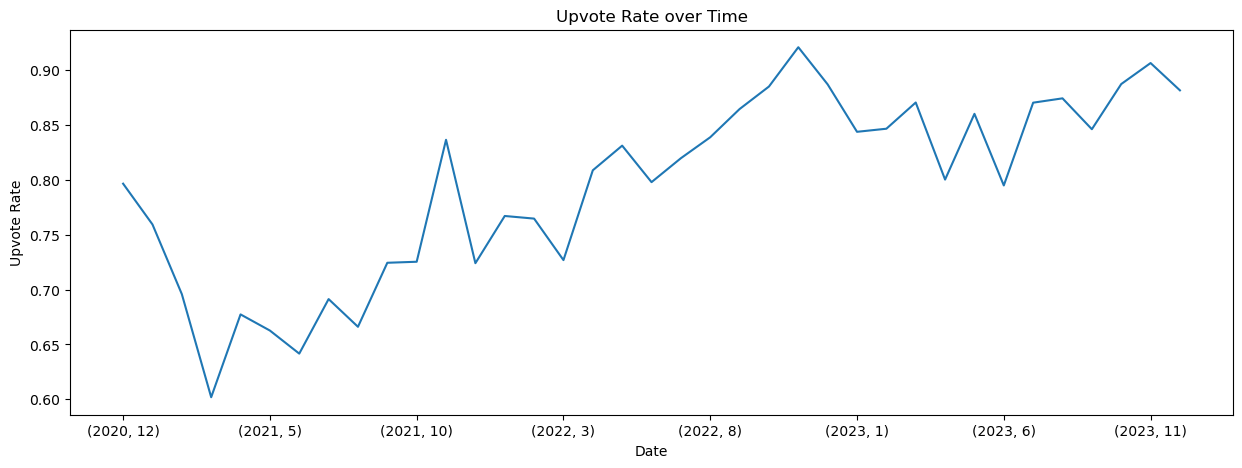

In [5]:
upvote_rate = df.groupby([df['date'].dt.year, df['date'].dt.month])["voted_up_for_game"].mean() #here we are grouping and calculating the mean
upvote_rate.plot(kind="line", figsize=(15, 5), title="Upvote Rate over Time", xlabel="Date", ylabel="Upvote Rate") #plotting the graph
plt.show()

It seems that the upvote rate has increased over time. This means that the developers have improved the game over time. There was an initial phase of high upvote rate but that happens to every game when it hasn't been played thoroughly yet. We can see it dipping heavily and thats when people realized the developers did a bad job. This is when Cyberpunk was in the news for all the wrong reasons. However, the upvote rate has increased over time which means that the developers have improved the game over time.

### Hours played statistics

Now let's see the statistics on hours played at the time of the review. This will help us understand how much the reviewers have played the game before reviewing it.

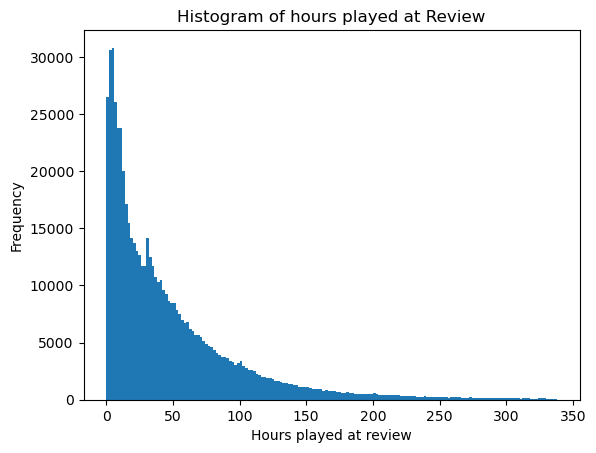

In [6]:
# Create a histogram
plt.hist(df['hours_played'], bins=int(df['hours_played'].max()/2))

# Add labels and title
plt.xlabel('Hours played at review')
plt.ylabel('Frequency')
plt.title('Histogram of hours played at Review')

# Show the histogram
plt.show()

It seems that there are many reviews with hours played between 0 to 50. This means that many reviewers have played the game for less than 50 hours before reviewing it. This is not enough time to review the game properly. However, there are also many reviews with hours played between 50 to 100. This means that many reviewers have played the game for more than 50 hours before reviewing it. This is enough time to review the game properly. So it might be possible that the reviews with hours played between 50 to 100 are more accurate than the reviews with hours played between 0 to 50.

## Hypothesis Testing

Here, we will be performing hypothesis testing on the dataset. We will be testing 3 different hypotheses. Namely, we will be testing if playtime affects the review positively, if trolls are more likely to vote down the game, and if ascii art affected upvotes.

*for the tests, our alpha will be 0.05*

### Hypothesis 1: the longer the playtime, the more likely the review is positive


*HO:* longer playtime does not affect the voted up rate

*HA:* longer playtime affects the voted up rate

Let us perform logistic regression to test this hypothesis.

In [7]:
# performing logistic regression

df["intercept"] = 1
print(df[["hours_played", "intercept"]].shape) #checking the shape of the dataset
logit_model = sm.Logit(df["voted_up_for_game"], df[["hours_played", "intercept"]]) #creating the logistic regression model
result = logit_model.fit() #fitting the model

print(result.summary())

(606133, 2)
Optimization terminated successfully.
         Current function value: 0.488026
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      voted_up_for_game   No. Observations:               606133
Model:                          Logit   Df Residuals:                   606131
Method:                           MLE   Df Model:                            1
Date:                Tue, 07 May 2024   Pseudo R-squ.:                 0.01342
Time:                        22:59:05   Log-Likelihood:            -2.9581e+05
converged:                       True   LL-Null:                   -2.9983e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
hours_played     0.0065   7.86e-05     82.328      0.000       0.006       0.007
intercept  

Since the P value of hours_played of 0.000 denoted by P>|z| is less than 0.05, we can reject the null hypothesis. 
 
Therefore, the longer the playtime, the more likely the review is positive.

Next, we will plot the curve against actual mean upvote rate.

C:\Users\Dahong Luo\AppData\Local\Temp\ipykernel_107264\2930194458.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(bins)['voted_up_for_game'].mean()


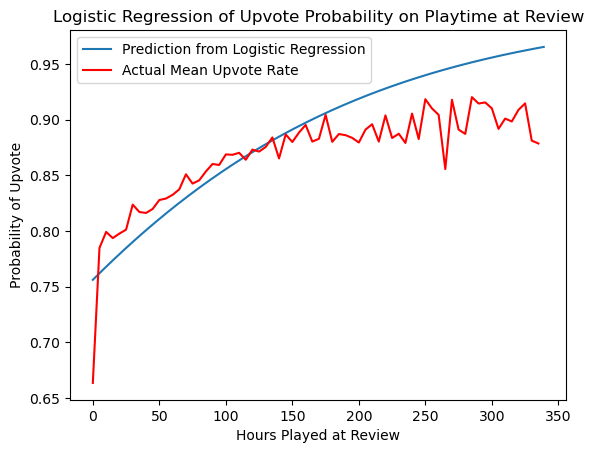

In [8]:
playtime_range = np.arange(0, df['hours_played'].max() + 1, 1) #creating a range of playtime
probabilities = result.predict(np.array([playtime_range,np.ones(playtime_range.shape)]).T)
plt.plot(playtime_range, probabilities) #plotting the graph

step = 5
bins = pd.cut(df['hours_played'], bins=range(0, int(df['hours_played'].max()+step), step)) #creating bins
grouped_df = df.groupby(bins)['voted_up_for_game'].mean()
plt.plot(np.arange(0, df['hours_played'].max(), step), grouped_df, color='red') #plotting the graph


plt.xlabel('Hours Played at Review')
plt.ylabel('Probability of Upvote')
plt.legend(['Prediction from Logistic Regression', 'Actual Mean Upvote Rate'])
plt.title('Logistic Regression of Upvote Probability on Playtime at Review')
plt.show()

Hmm, the curve is fitting the data pretty good. The curve is also increasing. This means that the longer the playtime, the more likely the review is positive.

### Hypothesis 2: Those who did not buy the game on steam are most likely trolls and will not vote up
*HO:* buying the game on steam does not affect the voted up rate

*HA:* buying the game on steam affects the voted up rate

Let us create a contingency table to test this hypothesis.

In [9]:
contingency = pd.crosstab(df["voted_up_for_game"], df["steam_purchase"]) #creating a contingency table
result = chi2_contingency(contingency) #performing the chi-squared test
print(result)

Chi2ContingencyResult(statistic=1903.13689134948, pvalue=0.0, dof=1, expected_freq=array([[ 12564.97788439, 106176.02211561],
       [ 51575.02211561, 435816.97788439]]))


The statistic is a really high number at 1903.13689134948 and the p-value is 0.0 which is less than 0.05, so we can reject the null hypothesis.  
This is a strong evidence that online trolls literally just voted down the game without even buying it. This finding is consistent with online trolls' behavior.

Plotting a heatmap to visualize the contingency table.

<Axes: xlabel='steam_purchase', ylabel='voted_up_for_game'>

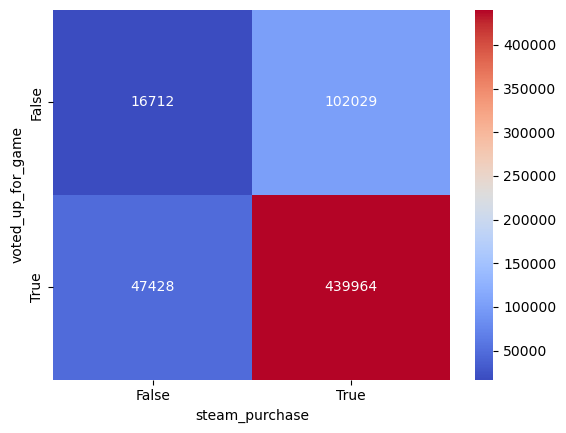

In [10]:
sns.heatmap(contingency, annot=True, cmap='coolwarm', fmt='d')

From just a quick glance, we can see that the people who did not buy the game on steam are most likely trolls and will not vote up.

### Hypothesis 3: ASCII art = more upvotes
*H0:* reviews having ascii art have the same average upvote rate as reviews without ascii art.

*HA:* reviews having ascii art have a higher average upvote rate than reviews without ascii art.

Let us first create a new column to check if the review has ascii art or not.

In [11]:
#alll ascii art on steam have the braille symbols which have the unicode range of 2800 to 28FF according to manual inspection of the dataset and general knowledge
df['has_ascii_art'] = df['review'].apply(lambda x: True if any(c for c in x if ('\u2800' <= c <= '\u28FF')) else False)

Now, let us perform a t-test to test this hypothesis.

In [12]:
ascii_art = df[df['has_ascii_art']]
no_ascii_art = df[~df['has_ascii_art']]
#performing a t-test
t_stat, p_val = ttest_ind(ascii_art["upvotes_on_comment"] + ascii_art["funny_votes_on_comment"], no_ascii_art['upvotes_on_comment']+ no_ascii_art['funny_votes_on_comment'], alternative='greater')

print(f"p-value: {p_val}")

p-value: 4.560562825877745e-24


Since the p-value of 4.560562825877745e-24 is less than the alpha value 0.05, we reject the null hypothesis and conclude that reviews with ascii art have a higher average upvote rate than reviews without ascii art.

Plotted a boxplot to visualize the data.

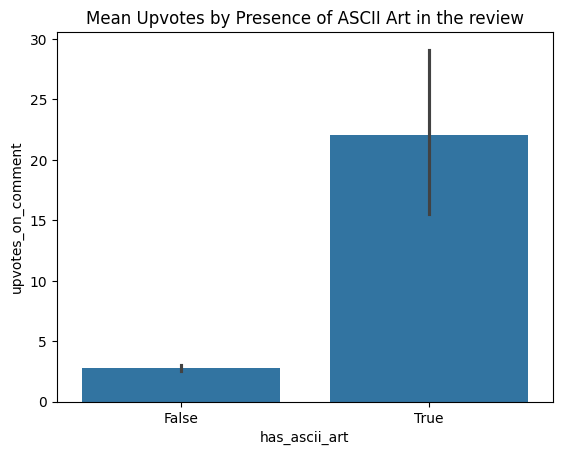

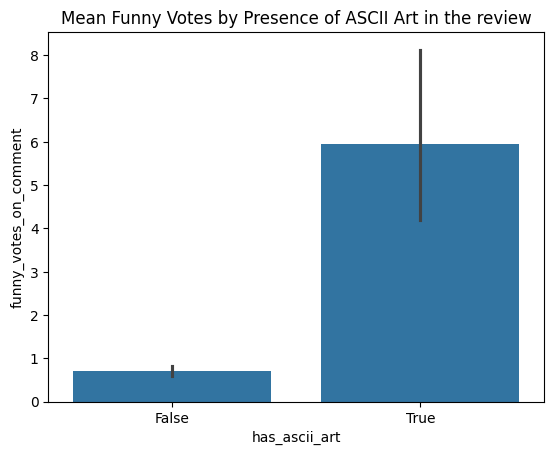

In [71]:
sns.barplot(x='has_ascii_art', y='upvotes_on_comment', data=df, estimator=np.mean)
plt.title('Mean Upvotes by Presence of ASCII Art in the review')
plt.show()

sns.barplot(x='has_ascii_art', y='funny_votes_on_comment', data=df, estimator=np.mean)
plt.title('Mean Funny Votes by Presence of ASCII Art in the review')
plt.show()

We can see that reviews with ascii art have a higher average upvote rate and funny rate than reviews without ascii art.

# __Primary Data Analysis__

Part 1: We will finetune DistilBERT model for sentiment analysis on the reviews. We can then use this model to predict the sentiment of unseen reviews. This helps us in analysis of steam reviews in general and would help us understand the sentiment of the reviews in the future for any game.

Part 2: We will create a Gradient Boosted Tree model to predict the number of upvotes the comment will get in the future. This will help us determine what comments we should push upwards so that other users can see it. This will help us understand what makes a review popular on steam.

## Part 1: Sentiment Analysis

Here we are going to finetune the DistilBERT model for sentiment analysis on the reviews.

First, let us gather the necessary data and then we will clean the data

In [119]:
df2 = df[['language', 'review', 'voted_up_for_game', 'hours_played', 'steam_purchase', 'has_ascii_art']]

df2 = df2.dropna() #remove rows that have missing values
df2 = df2[df2['review'] != ''] #remove rows that have empty strings because they are not useful
df2 = df2[df2['hours_played'] > 25] #remove rows that have less than 25 hours played as theyre useless
df2 = df2[df2['language'] == 'english'] #remove rows if language is not english in order to simplify the analysis
df2 = df2[df2['steam_purchase'] == True] #remove troll reviews
df2 = df2[df2['has_ascii_art'] == False] #we're not here to analyze ascii art but to analyze the reviews
df2 = df2[df2['review'].apply(lambda x: len(x.split()) > 25)] #remove rows that have less than 25 words as they are not useful
df2 = df2[~df2['review'].str.contains('█')] #remove rows that have the block character as they are not useful
df2 = df2[['review', 'voted_up_for_game']] #now keep only the columns that are useful for the model since we have removed the rest
df2['voted_up_for_game'] = df2['voted_up_for_game'].map({True: 1, False: 0}) #we now map the boolean values to 1 and 0
df2 = df2.dropna()
df2 = df2.drop_duplicates()

checking our data

In [120]:
df2.head()

,review,voted_up_for_game
0,It's very fun. I don't usually like open world...,1
6,Coming back to try the game after 2.0 came out...,0
11,Todo valio la pena al final con el mejor endin...,1
18,"Do you like Immersion, Becoming utterly lost a...",1
44,good game well worth a play. story gets kinda ...,1


In [121]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67124 entries, 0 to 612267
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review             67124 non-null  object
 1   voted_up_for_game  67124 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


perfect! we have the data we need. Now let's do some quick analysis on the data. let's see the length of the reviews.

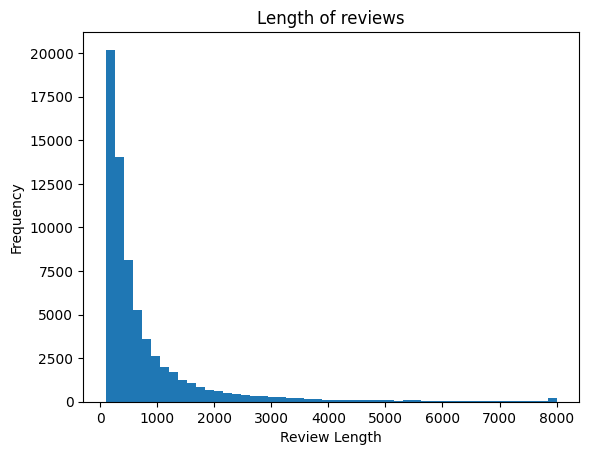

In [122]:
#plot length of reviews
plt.hist(df2['review'].apply(len), bins=50)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Length of reviews')
plt.show()

It seems that most reviews are below 512 words long, that's our limit for the DistilBERT model anyway. So we are good to go. Now let's setup for the training. We shall use cuda for training. Anything else (including macs) is for the weak.

In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #while I will be using cuda, others may not have it so I have added this line

now lets setup some variables

NOTE: We changed epochs and experimented with it. It's a hyperparameter after all.

In [124]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
max_length = 512
batch_size = 8
optimizer = Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)
epochs = 2 #this has been changed, we have experimented with this
training_loss = []
validation_loss = []

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


A quick check if the model exists in the directory. If it does, we load it. If not, we train it. This is so that we don't have to train the model everytime we run the notebook.

In [125]:
#A quick check if the model exists in the directory. If it does, we load it. If not, we train it. This is so that we don't have to train the model everytime we run the notebook.

try:
    model.load_state_dict(torch.load('320_final_model'))
    model.eval()
    print('MODEL FOUND, DO NOT RUN THE TRAINING CELL BELOW')
except:
    print("MODEL NOT FOUND, TRAIN THE MODEL")

MODEL NOT FOUND, TRAIN THE MODEL


Now let us define a tokenizer function that tokenizes and truncates, then we will split the data into training and validation sets. Then we will encode the data and transfer it to the GPU. DO NOT RUN IF MODEL IS FOUND.

In [126]:
def tokenize(review):
    tokens = tokenizer.encode_plus(
        review,
        truncation=True, #truncating the tokens to the max length which is 512
        padding="max_length", #padding the tokens to the max length which is 512
        return_attention_mask=True, #attention mask is used to tell the model which tokens to pay attention to and which to ignore
        add_special_tokens=True, #this is for the special tokens that DistilBert uses
        max_length=max_length, #max length is 512
    )
    inputs = torch.tensor(tokens["input_ids"]).to(device) #converting the input ids to a tensor and moving it to GPU
    attmsk = torch.tensor(tokens["attention_mask"]).to(device) #converting the attention mask to a tensor and moving it to GPU
    return inputs, attmsk

Now lets split the data and encode and move to GPU.

In [130]:
X_train, X_test, y_train, y_test = train_test_split(df2['review'].values, df2['voted_up_for_game'].values, test_size=0.2, random_state=42) #splitting the data into training and testing data

inputs_X_train = [tokenize(review) for review in X_train] #tokeniizing the training data
inputs_X_test = [tokenize(review) for review in X_test] #tokenizing the testing data
X_train2 = torch.stack([inputs[0] for inputs in inputs_X_train]) #stacking the training data
X_test2 = torch.stack([inputs[0] for inputs in inputs_X_test]) #stacking the testing data
train_mask = torch.stack([inputs[1] for inputs in inputs_X_train]) #stacking the atention mask for the training data
test_mask = torch.stack([inputs[1] for inputs in inputs_X_test]) #stacking the attention mask for the testing data

y_train2 = torch.tensor(y_train, dtype=torch.long).to(device) #converting the training data to a tensor and moving it to GPU
y_test2 = torch.tensor(y_test, dtype=torch.long).to(device) #converting the testing data to a tensor and moving it to GPUq

train_data = TensorDataset(X_train2, train_mask, y_train2) #creating a tensor dataset for the training data, this is used to create a data loader
train_sampler = RandomSampler(train_data) #creating a random sampler for the training data, a random sampler is used to shuffle the data
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) #creating a data loader for the training data, a data loader is used to load the data in batches

#now we do the same for test

test_data = TensorDataset(X_test2, test_mask, y_test2)
test_sampler = SequentialSampler(test_data) #we use a sequential sampler instead of random sampler for the test data because we don't want to shuffle the test data
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Now, we shall finally train the model! This will take some time. Luckily, we have a GPU.

In [131]:
for epoch in range(epochs):

    model.train #set the model to training mode
    total_train_loss = 0 #initialize the total training loss to 0
    progress_bar = tqdm(train_dataloader, total=len(train_dataloader), leave=True, desc = f'epoch {epoch + 1}', position=0)

    for batch in progress_bar: #for each batch in the training data, we use progress bar to show the progress
        batch = tuple(t.to(device) for t in batch)
        input_ids = batch[0] #input ids
        mask = batch[1] #att mask
        labels = batch[2] #labels
        optimizer.zero_grad() #set the gradients to zero
        outputs = model(input_ids, attention_mask=mask, labels=labels) #get the outputs from the model
        loss = outputs.loss #now we get the loss
        total_train_loss += loss.item()  #add the loss to the total training loss
        loss.backward() #bakcpropagation, the best thing of this
        optimizer.step() #step the optimizer
        progress_bar.set_postfix({'Training loss': total_train_loss / len(train_dataloader)})

    training_loss.append(total_train_loss / len(train_dataloader)) #append the training loss to the training loss list

    model.eval() #set the model to evaluation mode
    total_test_loss = 0 #initialize the total test loss to 0
    progress_bar = tqdm(test_dataloader, leave=True, total=len(test_dataloader), desc = f'epoch {epoch + 1}', position=0)

    for batch in progress_bar:

        with torch.no_grad(): #we do this because we don't want to calculate the gradients for the test data
            batch = tuple(t.to(device) for t in batch)
            input_ids = batch[0]
            mask = batch[1]
            labels = batch[2]

            outputs = model(input_ids, attention_mask=mask, labels=labels) #get the outputs from the model
            loss = outputs.loss #get the loss
            total_test_loss += loss.item()
            #we dont backpropagate here because we are not training the model
            progress_bar.set_postfix({'Validation loss': total_test_loss / len(test_dataloader)})

    validation_loss.append(total_test_loss / len(test_dataloader))

    #now we print necessary information
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Training Loss: {training_loss[-1]}")
    print(f"Validation Loss: {validation_loss[-1]}")

epoch 1: 100%|██████████| 1679/1679 [04:55<00:00,  5.68it/s, Validation loss=0.167] 


Epoch 1/2
Training Loss: 0.1755063012321222
Validation Loss: 0.16723084198715893


epoch 2: 100%|██████████| 1679/1679 [04:55<00:00,  5.68it/s, Validation loss=0.158] 

Epoch 2/2
Training Loss: 0.08988753507845139
Validation Loss: 0.15837545822178786


Now we save the model so that we don't have to train it again.

In [132]:
model.save_pretrained('320_final_model')

Now lets plot the training and validation loss.

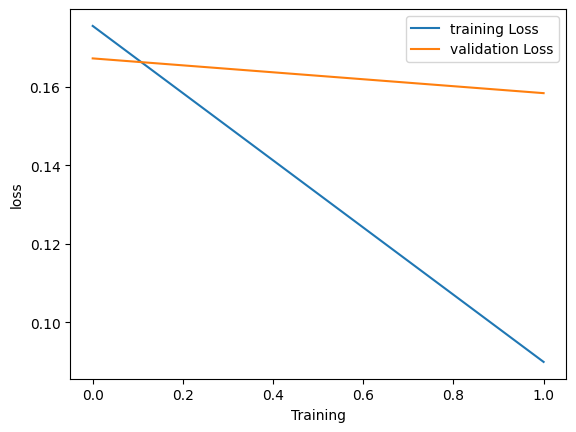

In [133]:
plt.plot(training_loss, label='training Loss')
plt.plot(validation_loss, label='validation Loss')
plt.xlabel('Training')
plt.ylabel('loss')
plt.legend()
plt.show()

Lets evaluate the model on the test set. We will also calculate the accuracy of the model.

In [134]:
model.eval() #set the model to evaluation mode
actual = []
prediction = []
for batch in test_dataloader: #for each batch in the test data
    with torch.no_grad(): #we do this because we don't want to calculate the gradients for the test data
        batch = tuple(t.to(device) for t in batch)
        input_ids = batch[0]
        mask = batch[1]
        labels = batch[2]

        outputs = model(input_ids, attention_mask=mask)
        actual.extend(labels.cpu().numpy()) #add the actual values
        prediction.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy()) #get the predictions

print(classification_report(actual, prediction)) #print the classification report

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      2305
           1       0.96      0.97      0.97     11120

    accuracy                           0.94     13425
   macro avg       0.90      0.90      0.90     13425
weighted avg       0.94      0.94      0.94     13425



Woah that's pretty nice accuracy, precision, and recall!

Now lets print the accuracy based on the previous actual and prediction values we got

In [136]:
accuracy = accuracy_score(actual, prediction)
print(f"accuracy: {accuracy}")

accuracy: 0.942048417132216


Now finally, let's plot a confusion matrix. A confusion matrix is a table that describes the performance of a classification model on test data

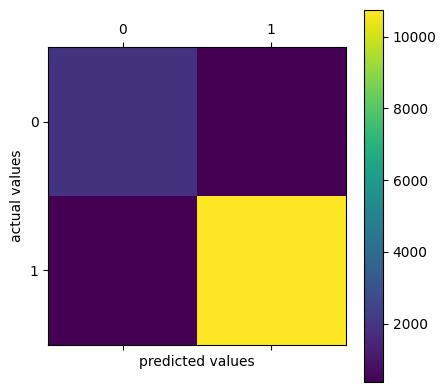

In [138]:
matrix = confusion_matrix(actual, prediction)
plt.matshow(matrix)
plt.colorbar()
plt.xlabel('predicted values')
plt.ylabel('actual values')
plt.show()

## Part 2: Upvotes prediction

We will be using a gradient boosted tree model to predict the number of upvotes a review will get.

First, we will preprocess the data.

Let's see how many languages are there

In [13]:
df["language"].unique()

array(['english', 'french', 'schinese', 'koreana', 'spanish', 'brazilian',
       'russian', 'turkish', 'tchinese', 'german', 'italian',
       'portuguese', 'ukrainian', 'norwegian', 'polish', 'thai',
       'finnish', 'czech', 'danish', 'hungarian', 'dutch', 'latam',
       'swedish', 'vietnamese', 'japanese', 'romanian', 'indonesian',
       'greek', 'bulgarian'], dtype=object)

Now let's clean and preprocess the data.

In [14]:
def preprocess(df):
    # combine both Chinese languages
    df['language'] = df['language'].replace('schinese', 'chinese')
    df['language'] = df['language'].replace('tchinese', 'chinese')
    
    # adding words_count
    # separating between asian language and other languages since Chinese, Korean, Japanese does not have spaces between words
    df.loc[df['language'].isin(['chinese', 'koreana', "japanese"]), 'words_count'] = df['review'].apply(lambda x: len(x))
    df.loc[~df['language'].isin(['chinese', 'koreana', "japanese"]), 'words_count'] = df['review'].apply(lambda x: len(x.split()))
    
    # adding days_since_updated
    df["days_since_updated"] = (df["date"].max() - df["date"]).dt.days
    
    # adding spoiler_inlcuded which checks if the review contains [spoiler] tag
    df["spoiler_included"] = df["review"].str.contains("[spoiler]", case=False)
    
    # removeing columns that are not needed
    df.drop(columns=["review","date","funny_votes_on_comment","intercept"], inplace=True)
    
    # changing the category of the language column
    df["language"] = df["language"].astype("category")
    
    return df

a little more processing

In [15]:
df_copy = df.copy()
preprocess(df_copy)
df_copy

,language,voted_up_for_game,upvotes_on_comment,steam_purchase,hours_played,has_ascii_art,words_count,days_since_updated,spoiler_included
0,english,True,0,True,40.866667,False,39.0,0,True
1,french,False,0,False,55.816667,False,14.0,0,True
2,chinese,True,0,True,35.266667,False,8.0,0,False
3,english,True,0,True,172.066667,False,2.0,0,True
4,english,True,0,True,26.333333,False,1.0,0,True
...,...,...,...,...,...,...,...,...,...
612375,english,False,18,True,0.100000,False,11.0,1098,True
612376,english,True,19,False,0.100000,False,105.0,1098,True
612377,chinese,True,78,False,0.100000,True,2656.0,383,True
612378,english,True,709,False,0.083333,False,10.0,1098,True


Next, we will split the data into training, validating, and testing sets.

In [16]:
target = df_copy["upvotes_on_comment"]
df_copy.drop(columns=["upvotes_on_comment"],inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df_copy, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Finally, we will train the model.

In [17]:
d_train = lgb.Dataset(X_train, label=y_train)
d_val = lgb.Dataset(X_val, label=y_val)
params = {
    'objective':'regression_l1',
    'boosting':'gbdt',
    'verbose': 1,
    'seed': 42,
    'early_stopping_rounds':5,
    'learning_rate':0.3,
    'num_iterations':100,
    'num_leaves':100,
    'min_data_in_leaf':50,
    'min_child_weight':0,
    'min_split_gain':0,
    'device':'gpu',
    'min_data_in_bin':100
}
cate_features_name = ['language', "steam_purchase", 'has_ascii_art', 'spoiler_included', "voted_up_for_game"]
model = lgb.train(params, d_train, categorical_feature = cate_features_name, valid_sets = d_val)

c:\Users\Dahong Luo\.conda\envs\pytorch_env\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 387924, number of used features: 8
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 4 dense feature groups (1.48 MB) transferred to GPU in 0.004146 secs. 1 sparse feature groups
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 2.45309


Let's see how our model performed!

In [18]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

mae = mean_absolute_error(y_pred_train, y_train)
print('Training set loss (MAE):%.3f' % mae)

#Mean Absolute error (MAE) for validation set
mae = mean_absolute_error(y_pred_val, y_val)
print('Validation set loss (MAE):%.3f' % mae)

#Mean Absolute error (MAE) for test set
mae = mean_absolute_error(y_pred_test, y_test)
print('Test set loss (MAE):%.3f' % mae)

Training set loss (MAE):2.870
Validation set loss (MAE):2.453
Test set loss (MAE):2.956


Our model performs pretty well! Let's plot Frequency vs upvotes count difference now.

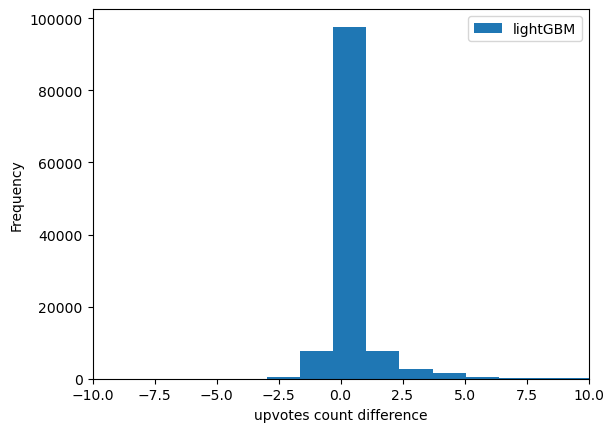

In [19]:
error_gb_train = y_train - y_pred_train
error_gb_test = y_test - y_pred_test

plt.hist(error_gb_test, bins=15000, label='lightGBM')
plt.ylabel('Frequency')
plt.xlabel('upvotes count difference')
plt.legend()
plt.xlim(-10,10)
plt.show()

# __Insights and Conclusions__

There are several insights that we can gather from the data. We will be discussing the insights and conclusions below:

- Looking over the upvote rate over time, it can be said that the developers improved the game in newer updates as the plot tends to increase over time.
- Looking at hours played at the time of the review, we can say that many reviewers have played the game for less than 50 hours before reviewing it. This is not enough time to review the game properly. Therefore, it may be possible that reviews created when the reviewer has had played the game for more than 50 hours reflect the state of the game more.
- The point above is further supported by the fact that probability of upvote increases as hours played increases.
- The ones who did not buy the game on steam have higher probability to downvote the game. Such people are called online trolls. This is consistent with the behavior of online trolls that is generally seen online.
- Having ASCII art in the review increases the chance of your review getting a funny or upvote by many times. This is because ASCII art is often seen as a fun way of introducing your review and people tend to like it more. From the ascii art we extracted (see asciiart.txt), many of these ASCII art are also funny or lewd and often refer to the current online meme culture. This makes it more likely to get upvoted or funny voted.
- It is possible to predict whether a reviewer gave a positive or negative review based on the review text. The model we trained has an accuracy of 0.94 after just 2 epochs which is good.
- Looking at the precision, recall, and f1-score in epoch 1 and epoch 2, we can say that steam reviews are a little different from the general reviews. The model performs well on the steam reviews only after two epochs of training. The precision increased from 0.84 to 0.96, the recall increased from 0.83 to 0.97, and the f1-score increased from 0.83 to 0.97 in the 2nd epoch of finetuning.
- The Gradient Boosted Tree model we made takes in days_since_review. We can change this value for any review to predict how many upvotes the review will get in the future.